In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)

import pandas as pd
import numpy as np

In [2]:
def pd2r(df):
    # For all columns with dtype = object (i.e. mixed dtypes)
    # Replace all NA's and NaN's with None
    df.loc[:, df.dtypes == object] = df.loc[:, df.dtypes == object].where((pd.notnull(df)), None)
    return df

In [3]:
nba_potw = pd2r(pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv'))

In [4]:
nba_potw_agg = nba_potw.groupby(['Player', 'Season short'])[['Date']].count().reset_index().rename(columns = {'Season short': 'Year', 'Date': 'Potw_Count'})

In [5]:
nba_player_stats = pd2r(pd.read_csv('../data/scraped/NBA_Player_Stats.csv'))

In [6]:
nba_player = pd.merge(left = nba_player_stats, right = nba_potw_agg, on = ['Player', 'Year'], how = 'left')
nba_player.Potw_Count = nba_player.Potw_Count.where((pd.notnull(nba_player.Potw_Count)), 0)

In [7]:
nba_player['MP_Prct'] = nba_player['MP'] / 48
nba_player['eFG_Prct'] = nba_player['eFG%']
nba_player['isPotw'] = np.where(nba_player['Potw_Count'] > 1, 'Yes', 'No')
nba_player_potw = nba_player.groupby(['Year', 'isPotw']).agg({'MP_Prct': 'mean', 'eFG_Prct': 'mean'}).reset_index()

In [8]:
%R -i nba_player_potw

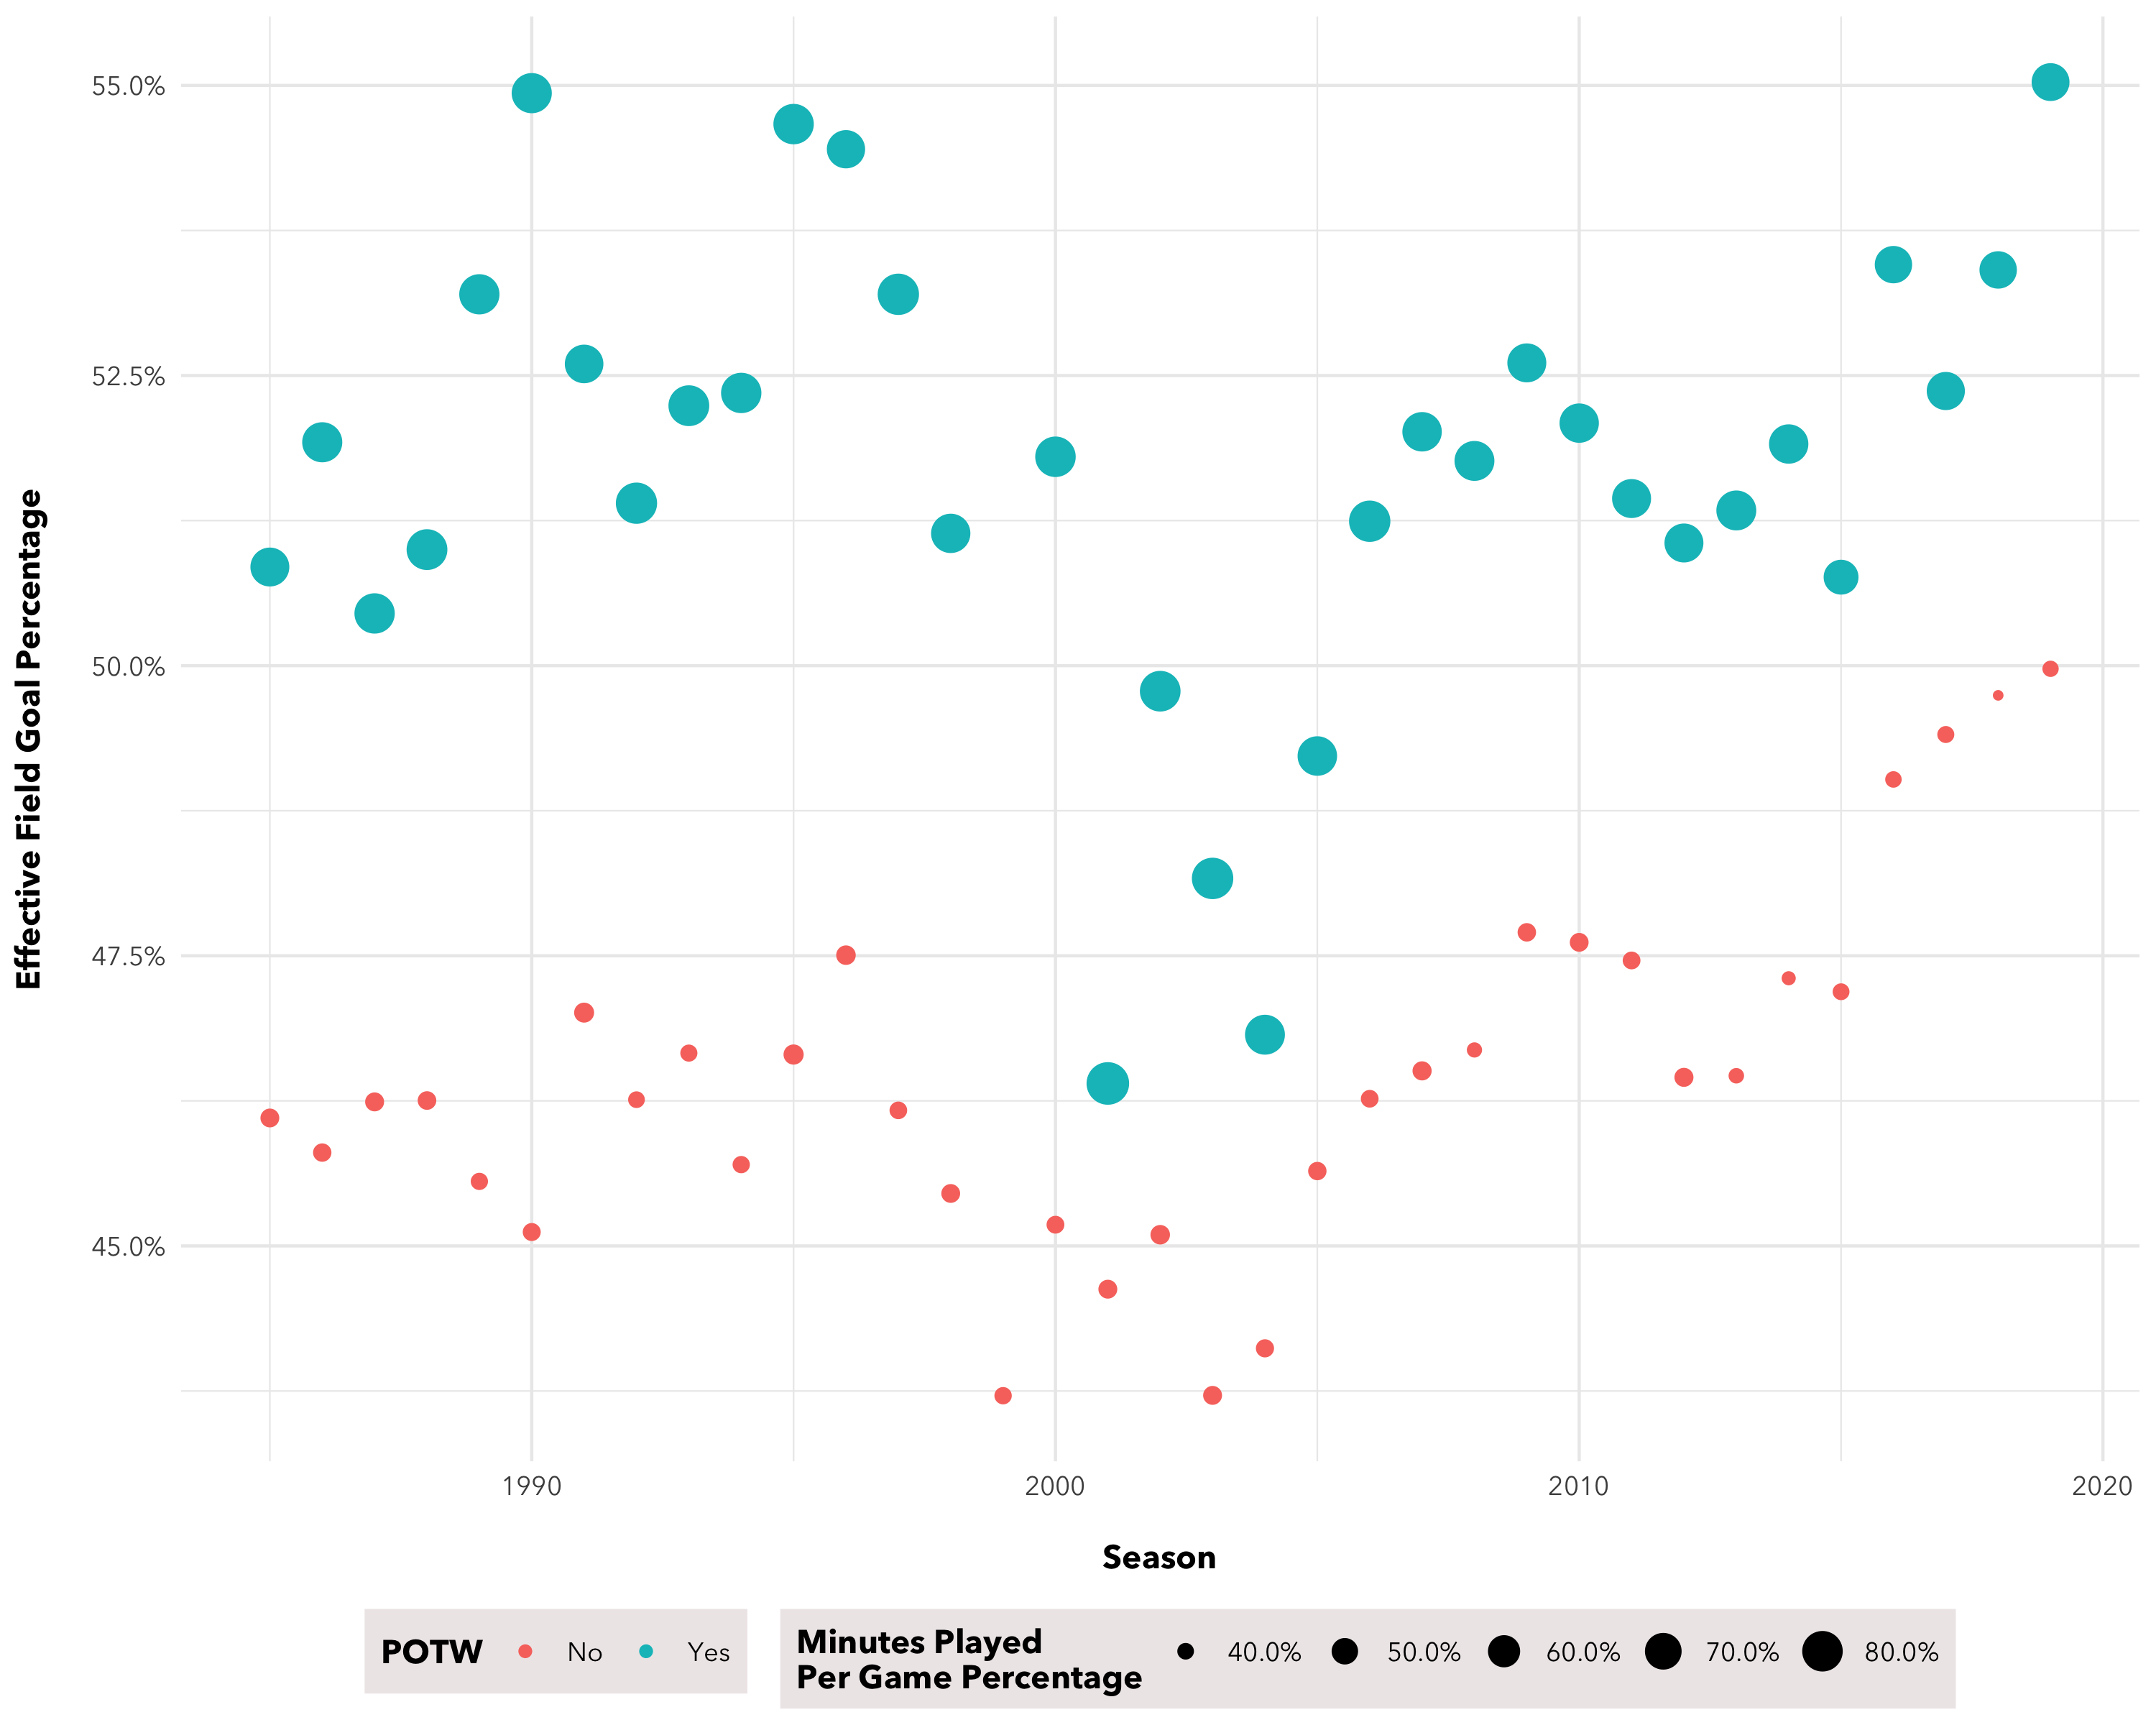

In [9]:
%%R -w 10 -h 8 --units in -r 300
ggplot() +
geom_point(aes(x = Year, y = eFG_Prct, size = MP_Prct, color = isPotw), data = nba_player_potw) +
scale_x_continuous(name = '\nSeason') +
scale_y_continuous(name = 'Effective Field Goal Percentage\n', label = percent) +
scale_size_continuous(name = 'Minutes Played\nPer Game Percentage', label = percent) +
scale_color_discrete(name = 'POTW') +
theme_minimal() +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      legend.title = element_text(face = 'bold'),
      legend.position = 'bottom',
      legend.background = element_rect(size = 0, fill = 'snow2'))